In [26]:
import astropy.units as u
import astropy.constants as const
from tdsat_telescope import load_telescope_parameters
from tdsat_sensitivity import src_rate, bgd_sky_qe_rate, bgd_electronics, calc_exposure, calc_snr
from tdsat_neff import get_neff
from bbmag import bb_abmag_fluence, bb_abmag
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
plt.rcParams['figure.figsize'] = [12,8]

In [3]:
# Telescope setup
read_noise = 3.*(2**0.5) # Read noise for two frames

point_drift = 1*u.arcsec # To be added to the PSF in quadrature
point_jitter = 5*u.arcsec
# Define bands
td1_band = [193, 233]*u.nm


# Transmission efficiency
trans_eff = (0.975)**8 # from Jim. 

print('Transmission efficiency: {}'.format(trans_eff))

# Load telescope info
config=11
diameter, qe, psf_size, pixel_size, efficiency = load_telescope_parameters(config)

area = np.pi * (diameter*0.5)**2
area_onaxis = np.pi * (0.5*24.2*u.cm)**2
efficiency = area_onaxis / area

print('Effective area (used) {}'.format(area*efficiency))



# Add in fuzz...
psf_size = (psf_size**2 + point_drift**2 + point_jitter**2)**0.5


print('Effective PSF size {}'.format(psf_size))
# Get the number of effective background pixels
neff = get_neff(psf_size, pixel_size)
print('Number of effective bgd pixels: {}'.format(neff))
print()

Transmission efficiency: 0.8166518036622619
Telescope Configuration 11
Name: Small Focal Plane CMOS
Entrance Pupil diameter 26.0 cm
Optical Efficiency 0.7893639053254439
PSF FWHM 4.288 arcsec
Pixel size 6.4 arcsec
Effective Aperture 23.1 cm
Effective Area 419.09631397051237 cm2
Effective area (used) 459.9605804120816 cm2
Effective PSF size 6.6623527375845235 arcsec
Number of effective bgd pixels: 2.990374488245114



In [42]:
# Other settings and background computation
light=True
texp = 300*u.s

dist0 = 10*u.pc
dist = [50,100,200]*u.Mpc

ab_vega = 1.73 # AB-Vega offset for Swift magnitudes

# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))

bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))


center = 208
width = 53
bandone=[center - 0.5*width, center+0.5*width]*u.nm

center = 284
width = 68
bandtwo=[center - 0.5*width, center+0.5*width]*u.nm

Sky background rate per pixel band1: 0.030369732491096913 1 / s
Sky background rate per pixel band2: 0.2478588509265617 1 / s


/Users/mheida/software/miniconda2/envs/envpy3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [6]:
# Load Tony's lightcurves
shock = np.loadtxt('input_data/shock.dat')
blukn = np.loadtxt('input_data/kilonova_blue.dat')

In [53]:
# Calculate absolute ABmags and photon rates in DUET bands for both models:

shock_lc = Table([shock[:,1]*u.s,np.zeros(len(shock))*u.ABmag,np.zeros(len(shock))*u.ABmag,np.zeros(len(shock))*1/(u.s*u.cm**2),np.zeros(len(shock))*1/(u.s*u.cm**2)],
               names=('time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'Shock model - mags and photon flux at 10pc'})

for k in range(len(shock[:,0])): 
    band1_mag, band2_mag = bb_abmag(bbtemp=shock[k,3]*u.K, bandone=bandone, 
                            bandtwo=bandtwo, swiftmag=(shock[k,14]+ab_vega)*u.ABmag,val=True)
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=shock[k,3]*u.K,
                            swiftmag=(shock[k,14]+ab_vega)*u.ABmag, light=light)
    shock_lc[k]['mag_D1'],shock_lc[k]['mag_D2'] = band1_mag,band2_mag
    shock_lc[k]['photflux_D1'],shock_lc[k]['photflux_D2'] = band1_fluence.value,band2_fluence.value

        
blukn_lc = Table([blukn[:,0]*u.s,np.zeros(len(blukn))*u.ABmag,np.zeros(len(blukn))*u.ABmag,np.zeros(len(blukn))*1/(u.s*u.cm**2),np.zeros(len(blukn))*1/(u.s*u.cm**2)],
               names=('time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'Shock model - mags and photon flux at 10pc'})

for k in range(len(blukn[:,0])): 
    band1_mag, band2_mag = bb_abmag(bbtemp=blukn[k,4]*u.K, bandone=bandone, 
                              bandtwo=bandtwo, swiftmag=(blukn[k,16]+ab_vega)*u.ABmag, val=True)
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=blukn[k,4]*u.K,
                            swiftmag=(blukn[k,16]+ab_vega)*u.ABmag, light=light)
    blukn_lc[k]['mag_D1'],blukn_lc[k]['mag_D2'] = band1_mag,band2_mag
    blukn_lc[k]['photflux_D1'],blukn_lc[k]['photflux_D2'] = band1_fluence.value,band2_fluence.value



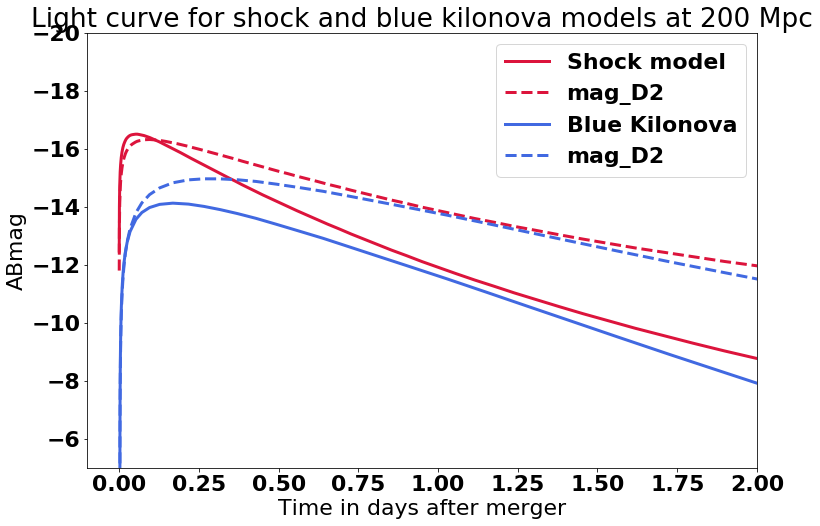

In [40]:
plt.plot(shock_lc['time'],shock_lc['mag_D1'], color='crimson', linestyle='-', linewidth=3, label='Shock model')
plt.plot(shock_lc['time'],shock_lc['mag_D2'], color='crimson', linestyle='--', linewidth=3)

plt.plot(blukn_lc['time'],blukn_lc['mag_D1'], color='royalblue', linestyle='-', linewidth=3, label='Blue Kilonova')
plt.plot(blukn_lc['time'],blukn_lc['mag_D2'], color='royalblue', linestyle='--', linewidth=3)

plt.axhline(y=22,xmin=0,xmax=1,color='black',linestyle=':')
plt.ylim(-5,-20)
plt.xlim(-0.1,2)
plt.legend()
plt.xlabel('Time in days after merger')
plt.ylabel(r'ABmag')
plt.title('Light curve for shock and blue kilonova models at 200 Mpc')
plt.show()

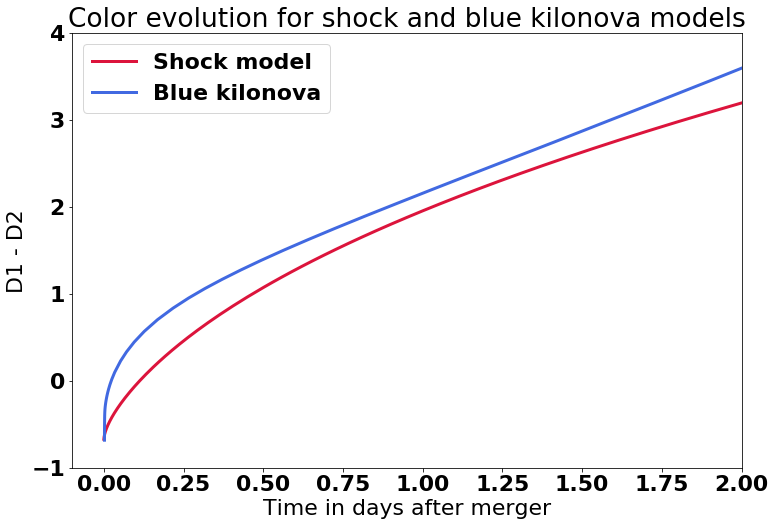

In [39]:
plt.plot(shock_lc['time'],shock_lc['mag_D1']-shock_lc['mag_D2'],linewidth=3, color='crimson', label='Shock model')
plt.plot(blukn_lc['time'],blukn_lc['mag_D1']-blukn_lc['mag_D2'],linewidth=3, color='royalblue', label='Blue kilonova')

plt.ylim(-1,4)
plt.xlim(-0.1,2)
plt.legend()
plt.xlabel('Time in days after merger')
plt.ylabel(r'D1 - D2')
plt.title('Color evolution for shock and blue kilonova models')
plt.show()

In [54]:
# Calculate S/N for both models:

shock_snr = np.zeros([len(dist),len(shock[:,0]),3])
shock_snr[:,:,0] = shock[:,1]
for j, distval in enumerate(dist):
    for i in range(len(shock[:,1])):
        band1_fluence = shock_lc['photflux_D1'].quantity[i]*(dist0.to(u.pc)/distval.to(u.pc))**2
        band2_fluence = shock_lc['photflux_D2'].quantity[i]*(dist0.to(u.pc)/distval.to(u.pc))**2
        band1_rate = trans_eff * efficiency * area * band1_fluence
        band2_rate = trans_eff * efficiency * area * band2_fluence
        snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
        snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
        shock_snr[j,i,1:3] = snr1,snr2

blukn_snr = np.zeros([len(dist),len(blukn[:,0]),3])
blukn_snr[:,:,0] = blukn[:,0]
for j, distval in enumerate(dist):
    for i in range(len(blukn[:,1])):
        band1_fluence = blukn_lc['photflux_D1'].quantity[i]*(dist0.to(u.pc)/distval.to(u.pc))**2
        band2_fluence = blukn_lc['photflux_D2'].quantity[i]*(dist0.to(u.pc)/distval.to(u.pc))**2
        band1_rate = trans_eff * efficiency * area * band1_fluence
        band2_rate = trans_eff * efficiency * area * band2_fluence
        snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
        snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
        blukn_snr[j,i,1:3] = snr1,snr2

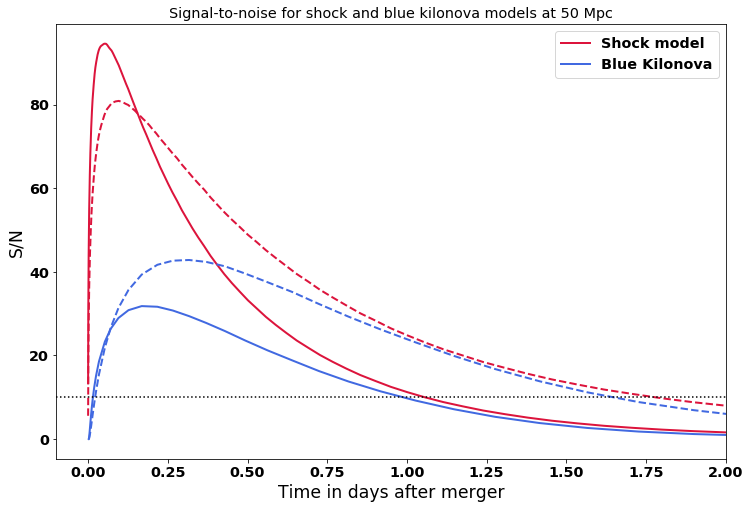

In [21]:
plt.plot(shock_snr[0,:,0],shock_snr[0,:,1], color='crimson', linestyle='-', linewidth=2, label='Shock model')
plt.plot(shock_snr[0,:,0],shock_snr[0,:,2], color='crimson', linestyle='--', linewidth=2)

plt.plot(blukn_snr[0,:,0],blukn_snr[0,:,1], color='royalblue', linestyle='-', linewidth=2, label='Blue Kilonova')
plt.plot(blukn_snr[0,:,0],blukn_snr[0,:,2], color='royalblue', linestyle='--', linewidth=2)

plt.axhline(y=10,xmin=0,xmax=1,color='black',linestyle=':')
#plt.ylim(26,18)
plt.xlim(-0.1,2)
plt.legend(fontsize='x-large')
plt.xlabel('Time in days after merger',fontsize='xx-large')
plt.ylabel(r'S/N',fontsize='xx-large')
plt.tick_params(axis='y',which='major',labelsize='x-large')
plt.tick_params(axis='x',which='major',labelsize='x-large')
plt.title('Signal-to-noise in 300s for shock and blue kilonova models at 50 Mpc  (low zodi)',fontsize='x-large')
plt.show()

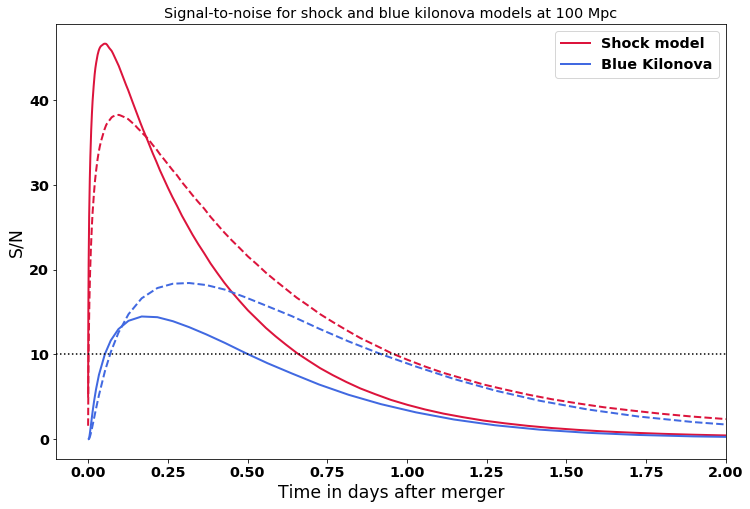

In [22]:
plt.plot(shock_snr[1,:,0],shock_snr[1,:,1], color='crimson', linestyle='-', linewidth=2, label='Shock model')
plt.plot(shock_snr[1,:,0],shock_snr[1,:,2], color='crimson', linestyle='--', linewidth=2)

plt.plot(blukn_snr[1,:,0],blukn_snr[1,:,1], color='royalblue', linestyle='-', linewidth=2, label='Blue Kilonova')
plt.plot(blukn_snr[1,:,0],blukn_snr[1,:,2], color='royalblue', linestyle='--', linewidth=2)

plt.axhline(y=10,xmin=0,xmax=1,color='black',linestyle=':')
#plt.ylim(26,18)
plt.xlim(-0.1,2)
plt.legend(fontsize='x-large')
plt.xlabel('Time in days after merger',fontsize='xx-large')
plt.ylabel(r'S/N',fontsize='xx-large')
plt.tick_params(axis='y',which='major',labelsize='x-large')
plt.tick_params(axis='x',which='major',labelsize='x-large')
plt.title('Signal-to-noise in 300s for shock and blue kilonova models at 100 Mpc  (low zodi)',fontsize='x-large')
plt.show()

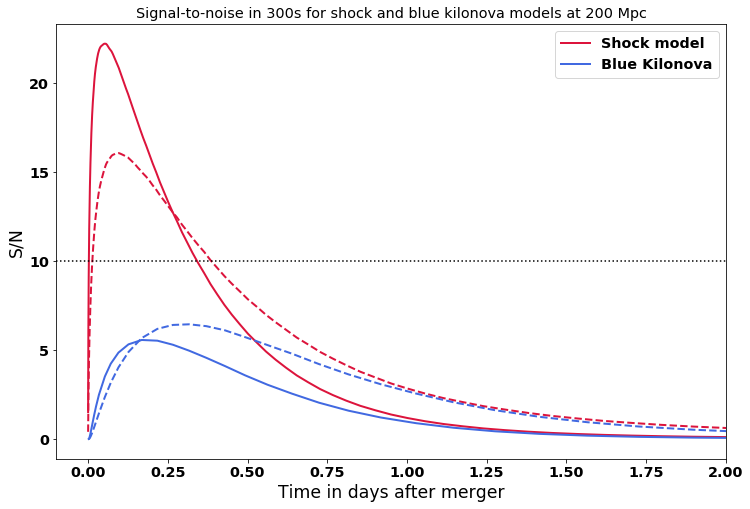

In [23]:
plt.plot(shock_snr[2,:,0],shock_snr[2,:,1], color='crimson', linestyle='-', linewidth=2, label='Shock model')
plt.plot(shock_snr[2,:,0],shock_snr[2,:,2], color='crimson', linestyle='--', linewidth=2)

plt.plot(blukn_snr[2,:,0],blukn_snr[2,:,1], color='royalblue', linestyle='-', linewidth=2, label='Blue Kilonova')
plt.plot(blukn_snr[2,:,0],blukn_snr[2,:,2], color='royalblue', linestyle='--', linewidth=2)

plt.axhline(y=10,xmin=0,xmax=1,color='black',linestyle=':')
#plt.ylim(26,18)
plt.xlim(-0.1,2)
plt.legend(fontsize='x-large')
plt.xlabel('Time in days after merger',fontsize='xx-large')
plt.ylabel(r'S/N',fontsize='xx-large')
plt.tick_params(axis='y',which='major',labelsize='x-large')
plt.tick_params(axis='x',which='major',labelsize='x-large')
plt.title('Signal-to-noise in 300s for shock and blue kilonova models at 200 Mpc (low zodi)',fontsize='x-large')
plt.show()

In [55]:
# Remove ABmag units, write to fits tables
shock_lc['mag_D1'].unit = None
shock_lc['mag_D2'].unit = None
blukn_lc['mag_D1'].unit = None
blukn_lc['mag_D2'].unit = None
shock_lc.write('blukn_lightcurve_DUET.fits', format='fits', overwrite=True)
blukn_lc.write('shock_lightcurve_DUET.fits', format='fits', overwrite=True)
shock_lc['mag_D1'].unit = u.ABmag
shock_lc['mag_D2'].unit = u.ABmag
blukn_lc['mag_D1'].unit = u.ABmag
blukn_lc['mag_D2'].unit = u.ABmag
